<a href="https://colab.research.google.com/github/123prashanth123/Fault-Detection-System/blob/main/VGG16%20AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Setup

In [ ]:
from IPython.display import clear_output

!pip install -q --upgrade imgaug
!pip install -q imagecorruptions

clear_output()

In [ ]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torchvision import models, transforms
from torchsummary import summary

from sklearn.model_selection import KFold

import os
import gc
from time import time

import imgaug
from imgaug import augmenters

import warnings
warnings.filterwarnings("ignore")

In [ ]:
TRANSFORM = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
SIZE = 224
SEED = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def breaker():
    print("\n" + 50*"*" + "\n")

# Build Dataloaders

In [ ]:
def build_dataloaders(num_samples: int, batch_size: int, path: str):
    breaker()
    print("Building Dataloaders ...")

    class DS(Dataset):
        def __init__(self, X=None, transform=None):
            self.X = X
            self.transform = transform
        
        def __len__(self):
            return self.X.shape[0]
        
        def __getitem__(self, idx):
            return self.transform(self.X[idx])
    
    def preprocess(image: np.ndarray) -> np.ndarray:
        return cv2.resize(src=cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB), dsize=(SIZE, SIZE), interpolation=cv2.INTER_AREA)
        
    imgaug.seed(SEED)
    # dataset_augment = augmenters.Sequential([
    #     augmenters.HorizontalFlip(p=0.25),
    #     augmenters.VerticalFlip(p=0.25),
    #     augmenters.SomeOf(5, [
    #             augmenters.blur.GaussianBlur(sigma=(0, 5), seed=SEED),
    #             augmenters.blur.MedianBlur(k=(1, 7), seed=SEED),
    #             augmenters.size.Crop(percent=(0, 0.1), seed=SEED),
    #             augmenters.geometric.Affine(rotate=(-45, 45), scale=(0.5, 1.2),translate_percent=(-0.2, 0.2), seed=SEED),
    #             augmenters.geometric.Rot90(k=(1, 3), seed=SEED),
    #             augmenters.arithmetic.Dropout(p=(0, 0.05), seed=SEED),
    #             augmenters.arithmetic.SaltAndPepper(p=(0, 0.05), seed=SEED),
    #             augmenters.color.MultiplyBrightness(mul=(0.5, 1.5)),
    #             augmenters.color.MultiplySaturation(mul=(0, 5), seed=SEED),
    #             augmenters.iaa_convolutional.Sharpen(alpha=(0.75, 1), lightness=(0.75, 1.25), seed=SEED),
    #             augmenters.iaa_convolutional.Emboss(alpha=(0.75, 1), strength=(0.75, 1.25), seed=SEED),
    #             augmenters.contrast.CLAHE(seed=SEED),
    #             augmenters.contrast.GammaContrast(gamma=(0.2, 5), seed=SEED), 
    #             ])
    #         ])
    dataset_augment = augmenters.Sequential([
        augmenters.HorizontalFlip(p=0.25),
        augmenters.VerticalFlip(p=0.25),
        augmenters.Rot90(k=(1, 3), seed=SEED),])
    
    image = preprocess(cv2.imread(path, cv2.IMREAD_COLOR))
    images = np.array(dataset_augment(images=[image for _ in range(num_samples)]))

    for tr_idx, va_idx in KFold(n_splits=5, shuffle=True, random_state=SEED).split(images):
        train_indices, valid_indices = tr_idx, va_idx
        break
    tr_images, va_images = images[train_indices], images[valid_indices]
    tr_data_setup, va_data_setup = DS(tr_images, TRANSFORM), DS(va_images, TRANSFORM)
    dataloaders = {"train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(SEED),) ,
                   "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)}
    return dataloaders

In [ ]:
def build_model():
    breaker()
    print("Building Model ...")

    class VGGAE(nn.Module):
        def __init__(self):
            super(VGGAE, self).__init__()

            self.encoder = models.vgg16_bn(pretrained=True, progress=True)
            for params in self.encoder.parameters():
                params.requires_grad = False
            for params in self.encoder.features[34:44].parameters():
                params.requires_grad = True
            self.encoder = nn.Sequential(*[*self.encoder.children()][:-2])

            self.decoder = nn.Sequential()
            self.decoder.add_module("DC1", nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=4, stride=2, padding=1))
            self.decoder.add_module("AN1", nn.ReLU())
            self.decoder.add_module("DC2", nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1))
            self.decoder.add_module("AN2", nn.ReLU())
            self.decoder.add_module("DC3", nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1))
            self.decoder.add_module("AN3", nn.ReLU())
            self.decoder.add_module("DC4", nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1))
            self.decoder.add_module("AN4", nn.ReLU())
            self.decoder.add_module("DC5", nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1))
            self.decoder.add_module("AN5", nn.Sigmoid())
        
        def getOptimizer(self, lr=1e-3, wd=0):
            trainable_params = [p for p in self.parameters() if p.requires_grad]
            return optim.Adam(trainable_params, lr=lr, weight_decay=wd)
        
        def getScheduler(self, optimizer=None, patience=None, eps=None):
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, eps=eps, verbose=True)
            
        def forward(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded
    
    torch.manual_seed(SEED)
    model = VGGAE()
    return model

# Train Helper

In [ ]:
def train(model, tr_data, va_data, epochs, lr, wd, es, device):

    def fit_(model=None, optimizer=None, scheduler=None, epochs=None, early_stopping_patience=None,
             trainloader=None, validloader=None, criterion=None, device=None,
             path=None, verbose=None): 
        breaker()
        print("Training ...")
        breaker()

        model.to(device)
        Losses = []
        bestLoss = {"train" : np.inf, "valid" : np.inf}
        DLS = {"train" : trainloader, "valid" : validloader}

        start_time = time()
        for e in range(epochs):
            e_st = time()
            epochLoss = {"train" : 0.0, "valid" : 0.0}

            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                
                lossPerPass = []

                for X in DLS[phase]:
                    X = X.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == "train"):
                        _, output = model(X)
                        loss = criterion(output, X)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass.append(loss.item())
                epochLoss[phase] = np.mean(np.array(lossPerPass))
            Losses.append(epochLoss)

            if early_stopping_patience:
                if epochLoss["valid"] < bestLoss["valid"]:
                    bestLoss = epochLoss
                    BLE = e + 1
                    torch.save({"model_state_dict": model.state_dict(),
                                "optim_state_dict": optimizer.state_dict()},
                            os.path.join(path, "state.pt"))
                    early_stopping_step = 0
                else:
                    early_stopping_step += 1
                    if early_stopping_step > early_stopping_patience:
                        print("\nEarly Stopping at Epoch {}".format(e + 1))
                        break
            
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e+1
                torch.save({"model_state_dict" : model.state_dict(),
                            "optim_state_dict" : optimizer.state_dict()},
                            os.path.join(path, "state.pt"))
            
            if scheduler:
                scheduler.step(epochLoss["valid"])
            
            if verbose:
                print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e + 1, epochLoss["train"], epochLoss["valid"], time() - e_st))

        breaker()
        print("Best Validation Loss at Epoch ---> {}".format(BLE))
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(epochs, (time() - start_time) / 60))
        breaker()
        print("Training Completed")
        breaker()

        return Losses, BLE
    
    optimizer = model.getOptimizer(lr=lr, wd=wd)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=25, eps=1e-12, verbose=True)
    checkpoint_path = os.path.join("/content/checkpoints")
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    L, BLE = fit_(model=model, optimizer=optimizer, scheduler=scheduler, epochs=epochs,
                  trainloader=tr_data, validloader=va_data, device=device,
                  criterion=nn.MSELoss(), early_stopping_patience=es,
                  path=checkpoint_path, verbose=True)

    TL, VL = [], []

    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])

    x_Axis = np.arange(1, len(L)+1)
    plt.figure(figsize=(8, 6))
    plt.plot(x_Axis, TL, "r", label="Training Loss")
    plt.plot(x_Axis, VL, "b--", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return BLE, checkpoint_path

# Main


**************************************************

Building Dataloaders ...

**************************************************

Building Model ...

**************************************************

Training ...

**************************************************

Epoch: 1 | Train Loss: 1.01029 | Valid Loss: 0.87370 | Time: 90.91 seconds
Epoch: 2 | Train Loss: 0.82506 | Valid Loss: 0.74971 | Time: 90.71 seconds
Epoch: 3 | Train Loss: 0.73099 | Valid Loss: 0.72141 | Time: 90.63 seconds
Epoch: 4 | Train Loss: 0.71661 | Valid Loss: 0.71082 | Time: 90.66 seconds
Epoch: 5 | Train Loss: 0.70832 | Valid Loss: 0.70603 | Time: 91.21 seconds
Epoch: 6 | Train Loss: 0.70506 | Valid Loss: 0.70510 | Time: 91.24 seconds
Epoch: 7 | Train Loss: 0.70260 | Valid Loss: 0.70119 | Time: 91.24 seconds
Epoch: 8 | Train Loss: 0.70018 | Valid Loss: 0.69941 | Time: 91.33 seconds
Epoch: 9 | Train Loss: 0.69921 | Valid Loss: 0.69860 | Time: 91.16 seconds
Epoch: 10 | Train Loss: 0.69798 | Valid Loss: 0.69748 | 

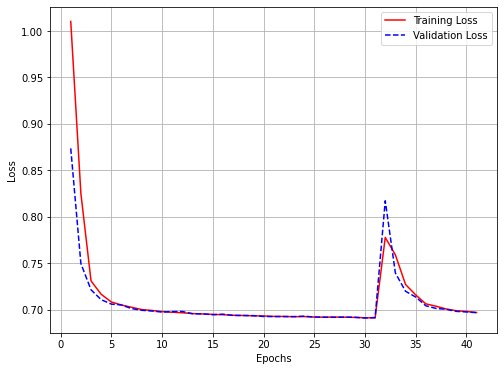

In [ ]:
def main():
    #################################
    num_samples = 10000
    batch_size = 128
    epochs = 100
    lr, wd = 1e-3, 1e-5
    early_stopping = 10
    #################################

    dataloaders = build_dataloaders(num_samples=num_samples, batch_size=batch_size, path="/content/Snapshot_1.png")
    model = build_model()
    # summary(model.to(DEVICE), (3, 224, 224), 64)
    BLE, path = train(model, dataloaders["train"], dataloaders["valid"], epochs, lr, wd, early_stopping, DEVICE)

    return model, BLE, path

model, BLE, path = main()

# Test


**************************************************

Building Model ...

**************************************************



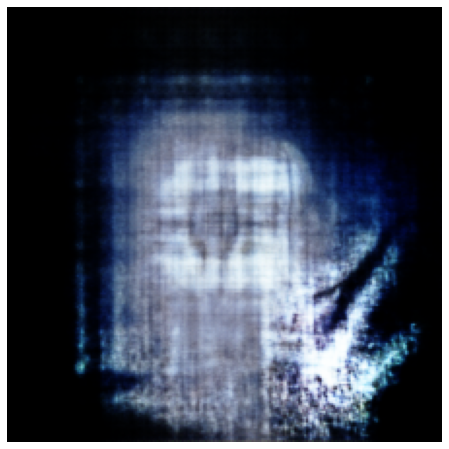

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
clear_output()


def test(model, path: str, drive_eval=False) -> None:
    def preprocess(image: np.ndarray) -> np.ndarray:
        return cv2.resize(src=cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB), dsize=(SIZE, SIZE), interpolation=cv2.INTER_AREA)
    
    if not drive_eval:
        model.load_state_dict(torch.load(os.path.join(path, "state.pt"), map_location=DEVICE)["model_state_dict"])
    else:
        model.load_state_dict(torch.load(path)["model_state_dict"])
        model.to(DEVICE)
    model.eval()

    image = preprocess(cv2.imread("/content/Snapshot_5.png", cv2.IMREAD_COLOR))

    with torch.no_grad():
        _, output = model(TRANSFORM(image).to(DEVICE).unsqueeze(dim=0))
    output = output[0].detach().cpu().numpy().transpose(1, 2, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(output)
    plt.axis("off")
    plt.show()

model = build_model()
breaker()
test(model, path="/content/gdrive/My Drive/vgg16_10k_ae_state.pt", drive_eval=True)

In [ ]:
# from google.colab import drive
# drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# !cp "/content/checkpoints/state.pt" "/content/gdrive/My Drive/vgg16_10k_ae_state.pt"